# Подготовка статистических данных для анализа и построения прогнозов с помощью Python(Pandas)
Основная идея проекта состоит в том, чтобы автоматизировать подготовку данных для анализ региональной статистики, информация по которой обновляется ежемесячно Росстатом (по ссылке https://rosstat.gov.ru/folder/11109/document/13259).

Данные включают сотню таблиц в десятках файлах MS Excel, собранных в rar-архив. Таблицы представляют собой матрицы со сводными данными о показателях социально-экономического положения регионов по различным периодам. При этом, если перечень субъектов анализа (регионов/округов) практически идентичен от таблицы к таблице, то периоды и единицы измерения в данных таблицы рознятся.

Так, данные могут быть представлены в виде индексов в %, а также в виде фактических показателей (млн руб., кв.м., квт*ч) и показателей накопленным итогом. Фактические показатели наблюдаются помесячно либо поквартально.
Индексы могут быть представлены в % к соответствующему периоду предыдущего года, в % к предыдущему месяцу и т.д.

### Подготовка таблицы для анализа посредством Pandas

Т.к. использование в исходном виде для составления сводных таблиц в Excel или визуализаций в Power BI затруднительно, с учетом большого количества файлов и таблиц с некоторыми различиями наиболее удобно осуществить обработку массива исходной информации с помощью библиотеки Python Pandas.

Итогом обработки исходных файлов должна стать аналитическая база данных, включающая основную таблицу статистических данных (FactStatistic), а также связанные с ней словари показателей, периодов и регионов. 

В словаре периодов (DimPeriods) собраны варианты наименований периодов на русском языке (отдельные месяцы и кварталы, а также периоды с начала года до соответствующего месяца) для распознавания и номер соответствующего месяца для перевода их в дату (что удобно для последующей навигации по базе данных).

В словаре регионов (DimRegions) собраны все их полные корректные наименования, короткие ключевые наименования для распознавания регионов из исходных таблиц (где наименования могут быть с ошибками и лишними символами), а также индексы регионов и округов соотнесения с таблицей фактов.

В ходе обработки файлов с исходными данными составляется словарь показателей (DimIndexes), включающий наименование статистического показателя ('Индекс промышленного производства', 'Объем инвестиций в основной капитал и т.д.') и способа представления (% к сопоставимому периоду, млн руб., тыс. кв. м. и т.д.).

#### Загрузка библиотек, исходных данных и подготовка словарей



In [1]:
import pandas as pd
import numpy as np
import rarfile
import re
rarfile.UNRAR_TOOL = r'C:\Program Files\WinRAR\UnRAR.exe'

In [2]:
# Загрузка архива с данными
archive = rarfile.RarFile('Data/info-stat-11-2022.rar', 'r')

# Загрузка словаря периодов
periods = pd.read_excel('Data/DimPeriods.xlsx')
periods['Period_id'] = periods.index

# Словарь для определения Period_id по исходному наименованию периода
periods_dict = periods.set_index('PeriodName').to_dict()['Period_id']

# Словарь для определния номера месяца по Period_id
month_dict = periods.set_index('Period_id').to_dict()['MonthNumber']

# Загрузка словаря регионов
region_dict = pd.read_excel('Data/DimRegions.xlsx')

### Подготовка исходного файла
Для сбора таблицы итоговой базы данных и связи ее с таблицами словарей для начала необходимо привести информацию каждой из исходных таблиц к общему формату, предполагающему наличие следующих данных: 
* 'Region_id', идентификатор региона/округа (int);
- 'Index', статистический показатель (float);
- 'Period', временная метка периода в формате datetime;
- 'Period_id', идентификатор периода (int);
- 'Index_id', идентификатор статистического показателя (int).

В ходе подготовки итоговой таблицы следует удалить из исходных данных строки с Архангельской областью и Тюменской областью с учетом автономных округов, с учетом того, что в данных есть показатели и по отдельным субъектам. Агрегированные при этом для расчета рэнкинга и анализа статистики на практике не используются.
Еще одной задачей на том этапе является объединение данных Забайкальского края и Республики Бурятии в одну строку с сохранением всех данных. В ряде случаев эти данные в двух отдельных строках: до 2018 года в разделе СФО и далее с 2018 года в ДВФО.
Кроме того, предобработка включает очистку данных от лишних символов, заполнение пустых значений, а также исправление наименований регионов и периодов содержащих ошибки.
    

In [3]:
# Функция для определения Period_id ближайшего похожего наименования периода в случае наличия ошибок в названии периода 
import jellyfish
def right_period(word):
    min_dist_idx = periods.PeriodName.apply(lambda x: jellyfish.damerau_levenshtein_distance(word, x)).idxmin()
    return periods.Period_id.loc[min_dist_idx]

In [4]:
# Функция для подготовки отдельной исходной таблицы в Excel для дальнейшей интеграции в общую таблицу базы данных
def df_transform(data):
    
    # Определение индекса строки начала таблицы (первый пропуск - строка после заголовка таблицы с указаниями годов)
    # Заголовок может занимать от двух до нескольких строк
    start_index = data[data[0].isna()].index[0]
    
    # Удаление пустых колонок (с учетом попадания мусорных данных)
    df = data.dropna(axis='columns', thresh = 2).copy(deep=True)
        
    # Разделение заголовка таблицы на название индекса и его описание, очистка строк от лишних символов
    df_title_main = df.loc[0, 0]
    df_title_main = re.sub(r' +', r' ', re.sub(r'\d+' , '', df_title_main.strip()))
    df_title_unit = '_'.join(df[1:start_index][0].to_list())
    df_title_unit = re.sub(r' +', r' ', re.sub(r'\d+' , '', df_title_unit.strip()))
    
    # Разделение таблиц с периодом и статистическими данными 
    period_df = df.loc[start_index:start_index+1, 1:]
    reg_df = df.loc[start_index+2:].dropna()
     
    #Удаление из статданных строк с Архангельской областью и Тюменской областью с учетом автономных округов 
    for region in ['Архангельская', 'Тюменская']:
        mask = reg_df[0].apply(lambda x: x.split()[0] == region)
        if sum(mask) > 1:
            reg_df.drop(index = reg_df[mask].index[0], inplace = True)

    #Объединение данных Забайкальского края и Республики Бурятии в одну строку 
    duplicated_df = np.array([reg_df[reg_df[0].duplicated(keep='last')].index.values, reg_df[reg_df[0].duplicated()].index.values]).T
    for row in duplicated_df:
        reg_df.loc[row[1], :].fillna(reg_df.loc[row[0], :], inplace=True)
        reg_df.drop(index = row[0], inplace=True)
    
    #Определение соответствующих индексов регионов через словарь region_dict
    regions_names = reg_df[0].apply(lambda x: re.sub(r'\d+' , '', x.replace('г.', '')).split())
    regions_idxs = regions_names.apply(lambda x: region_dict.query('Region_short in @x').Region_id.values[0])
    reg_df[0] = regions_idxs
    
    #Подготовка строки с датой
    period_df.iloc[0, :] = period_df.iloc[0, :].ffill()
    period_year = period_df.iloc[0, :].apply(lambda x: x.split()[0])
    period_name = period_df.iloc[1, :].apply(lambda x: str(re.sub(r' +', r' ', re.sub(r'[^-IVа-я ]+', r'', x.strip()))))
    #Определение индекса периода и номера месяца
    period_id = period_name.apply(lambda x: periods_dict.get(x, right_period(x)))
    period_month = period_id.apply(lambda x: month_dict.get(x))
    #Определение агрегированной строки с периодом (для дальнейшего перевода в дату) 
    #и индексом периода (для отображении корректного периода в рамках визуализаций)
    period = period_year + '-' + period_month.astype('str') + '_' + period_id.astype('str')
    period[0] = 'Region_id'
        
    #Развертывание исходной сводной таблицы в "длинный" формат, приведение индекса к единому формату
    reg_df.columns = period.sort_index()
    result = reg_df.melt(id_vars=['Region_id'], var_name = 'Period', value_name = 'Index')
    result['Index'] = result['Index'].apply(lambda x: re.sub(('-|\.\.\.|\…| '), '0', str(x).replace(',', '.'))).fillna(0)
    
    #Развертывание колонки с периодом на колонку с датой (для дальнейшего преобразования в формат Datetime) и идентификатором периода
    result = pd.concat([result, result.Period.str.split('_', expand=True)], axis=1).drop(columns='Period')
    result.rename(columns={0: 'Period', 1: 'Period_id'}, inplace=True)
    
    #Функция возвращает предобработанную таблицу с исходными данными, готовую к конкатенации с общей базой, полное наименование таблицы и описание индекса
    return result, df_title_main, df_title_unit

### Сбор итоговой базы данных
В рамках сбора итоговой таблицы осуществляется проход по файлам в архиве и выбор файлов формата *.xls, *.xlsx, с учетом списка исключений, содержащим индексы файлов, которые не подходят под общий формат. С помощью функции df_transform преобразуются таблицы каждого листа загружаемого файла и добавляются в общую итоговую таблицу.
Параллельно формируется таблица словаря показателей.

In [5]:
%%time

#Список исключений
stoplist = ['12-02', '12-03', '12-04', '12-05', '13-01', '15-01']

#Создание таблицы для сбора итоговой базы данных
result_df = pd.DataFrame(columns=['Region_id', 'Index', 'Period', 'Period_id', 'Index_id'])

#Создание таблицы для сбора наименований индексов
index_df = pd.DataFrame(columns=['IndexTitle', 'IndexUnit', 'SheetName'])
index_id = -1
 
#Проход по файлам в архиве
for name in archive.namelist():
    if (name[-3:] in ['xls', 'lsx']) and (re.search(r'/\d\d-\d\d', name).group()[1:] not in stoplist): 
        xlfile = archive.open(name)
        data_file = pd.ExcelFile(xlfile)
        
        #Проход по каждому листу файла
        for sheet in data_file.sheet_names:
            data_sheet = data_file.parse(sheet, header=None)
            
            data_prep, df_title_main, df_title_unit = df_transform(data_sheet)
            
            #Добавление показателя в таблицу индексов
            index_id += 1
            index_df.loc[index_id, 'IndexTitle'] = df_title_main
            index_df.loc[index_id, 'IndexUnit'] = df_title_unit
            index_df.loc[index_id, 'SheetName'] = sheet
                        
            #Добавление колонки с идентификатором показателя
            data_prep['Index_id'] = index_id
                
            #Добавление показателя в общую таблицу
            result_df = pd.concat([result_df, data_prep], ignore_index=True)
                
#Перевод данных итоговой таблицы в соответствующие форматы
result_df.Period = result_df.Period.astype('datetime64')
result_df.Period_id = result_df.Period_id.astype('int')
result_df.Index_id = result_df.Index_id.astype('int')
result_df.Region_id = result_df.Region_id.astype('int')
result_df.Index = result_df.Index.astype('float')
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603412 entries, 0 to 603411
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Region_id  603412 non-null  int32         
 1   Index      603412 non-null  float64       
 2   Period     603412 non-null  datetime64[ns]
 3   Period_id  603412 non-null  int32         
 4   Index_id   603412 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3)
memory usage: 16.1 MB
CPU times: total: 20.9 s
Wall time: 31.5 s


In [6]:
result_df_copy = result_df.copy(deep=True)

#### Форматирование таблицы наименований индексов
Сформированная таблица словаря показателей требует доработки. Во-первых это заполнение значений наименований индексов: вместо "продолжение", которое обозначается на всех листах книги, кроме заглавного. Во вторых унификация представлений показателей с учетом большого количества изначальных описаний, различающихся порой незначительно и содержащих мелкие ошибки.

In [7]:
#Заполнение значений наименований индексов: вместо "продолжение" на соответствующие значения
index_df.IndexTitle = index_df.IndexTitle.replace('продолжение', np.nan).ffill()

#Общее количество отдельных индексов (с учетом разных представлений каждого):
print('Всего таблиц:', index_df.shape[0]) 
print('Всего индексов:', index_df.IndexTitle.unique().size)
print('Всего описаний:', index_df.IndexUnit.unique().size)

Всего таблиц: 101
Всего индексов: 50
Всего описаний: 47


С учетом большого количества различных вариантов представлений индексов, а также наличия ошибок и мелких отличий в их описании для унификации и упрощения навигации добавляется колонка со значениями единиц измерения в общем формате

In [8]:
#Загрузка подготовленной таблицы с 14 унифицированными полными и сокращенными единицами измерения
units_idxs = pd.read_excel('IndexUnits.xlsx')
units_idxs.index.name = 'Unit_id'

#Подготавка словаря для конвертации полного наименования в индекс единицы измерения
units_dict = {v: k for k, v in units_idxs.to_dict()['IndexUnitFull'].items()}

#Функция для поиска наиболее подходящего значения единицы измерения в случае отсутствия прямых совпадений
def right_unit(word):
    min_dist_idx = units_idxs.IndexUnitFull.apply(lambda x: jellyfish.damerau_levenshtein_distance(word, x)).idxmin()
    return min_dist_idx

#Для поиска выбираются крайние справа значения в строке описания индекса 
index_df_short = index_df.IndexUnit.apply(lambda x: x.split('_')[-1].split(';')[-1])
index_df['IndexUnit_id'] = index_df_short.apply(lambda x: units_dict.get(x, right_unit(x)))
#Добавление унифицированных описаний индексов в общую таблицу в соответствии с определенным ранее идентификатором
index_df = index_df.join(units_idxs, on='IndexUnit_id')

#Общее количество представлений индексов сокращено:
print('Всего описаний:', index_df.IndexUnit.unique().size)
print('Всего вариантов представлений показателей c учетом унификации:', index_df.IndexUnitFull.unique().size)
print('Распределение способов представлений по количеству показателей:\n',
     index_df.groupby('IndexUnitFull')['IndexTitle'].count().sort_values(ascending=False))

Всего описаний: 47
Всего вариантов представлений показателей c учетом унификации: 14
Распределение способов представлений по количеству показателей:
 IndexUnitFull
В % к соответствующему периоду предыдущего года    21
В % к соответствующему месяцу предыдущего года     15
В % к декабрю предыдущего года                     12
В % к предыдущему месяцу                           11
Тыс. человек                                       10
Млн рублей                                          9
Млн долларов США                                    6
Рабочие места, тыс. человек                         4
Рублей                                              3
Тыс. кв. метров общей площади жилых помещений       3
В % к общему количеству                             2
Объем просроченной задолженности, млн рублей        2
Рублей за кв. метр общей площади                    2
Млн кВт*ч                                           1
Name: IndexTitle, dtype: int64


#### Выгрузка результата и словарей
Выгрузка в один файл xlsx результата и словарей удобна для дальнейшего использования в PowerBI либо непосредственно в Excel, занимает немного меньше места, но требует значительно больше времени, чем сохранение в csv.

In [9]:
%%time
with pd.ExcelWriter('Data/result_df.xlsx') as writer:  
    result_df.to_excel(writer, sheet_name='FactStatistic')
    index_df.to_excel(writer, sheet_name='DimIndexes')
    region_dict.to_excel(writer, sheet_name='DimRegions')
    periods.to_excel(writer, sheet_name='DimPeriods')
    
import os
print(os.path.getsize('Data/result_df.xlsx'))

17712363
CPU times: total: 1min 39s
Wall time: 1min 45s


## Построение визуализации 
На основе подготовленных данных можно построить визуализации с помощью библиотеки Seaborn.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Столбчатая диаграмма - основная, которую можно использовать в целях обзора временных рядов показателей региональной статистики. Далее приведены графики для ряда показателей регионов Ангаро-Енисейского макрорегиона: Республики Тывы, Республики Хакасия, Красноярского края и Иркутской области.
1. Индекс промышленного производства, в % к соответствующему периоду предыдущего года за 2022 год.
2. Индекс промышленного производства Красноярского края за 2022 год, в % к предыдущему месяцу и соответствующему месяцу предыдущего года. 
3. Объем инвестиций в основной капитал, в млн рублей.

In [11]:
# Функция подготовки выборки определенных регионов, показателей и периодов (годов) из базы данных таблицы 
def get_sample(df, index_idxs, region_idxs, year):
    sample = df.query('Index_id in @index_idxs & Region_id in @region_idxs')
    sample = sample[sample.Period.dt.year == year]
    sample = sample.join(region_dict.drop(columns='Region_short').set_index('Region_id'), on='Region_id')
    sample = sample.join(index_df, on='Index_id')
    sample = sample.join(periods.set_index('Period_id'), on='Period_id')
    return sample

In [12]:
#Функция построения столбчатой диаграммы 
#для нескольких регионов по одному показателю/нескольких показателей по одному региону за определенный год

def regions_barplt(result_df, index_idxs, region_idxs, year, category = 'percent'):
    sample_df = get_sample(result_df, index_idxs, region_idxs, year)
    sns.set_theme()
    plt.figure(figsize=(16, 6))
    font = {'family': 'Verdana',
            'color':  'darkred',
            'weight': 'normal',
            'size': 14,
            }
    
    if len(index_idxs) == 1:
        ax = sns.barplot(y='Index', x='PeriodName', data=sample_df, hue='Region_full')
        descr = ',\n' + sample_df.IndexUnitFull.iloc[0].lower()
    elif len(region_idxs) == 1:
        ax = sns.barplot(y='Index', x='PeriodName', data=sample_df, hue='IndexUnitFull')
        descr = ',\n' + sample_df.Region_full.iloc[0]
    else:
        print('Не предусмотрена возможность построения графика в данной конфигурации')
        return
        
    if sample_df.shape[0] > 12:
        for bar in ax.containers:
            ax.bar_label(bar, rotation=90, label_type='center', color='w', size=13)
    else:
        for bar in ax.containers:
            ax.bar_label(bar, size=13, padding=1)
        
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(0.8, 1), ncol=2, title=None, frameon=False,
    )
    ax.set_title(sample_df.IndexTitle.iloc[0] + descr, fontdict=font, loc='left')
    ax.set_xlabel(str(year) + ' год')
    ax.set_ylabel('')
    return plt.show()

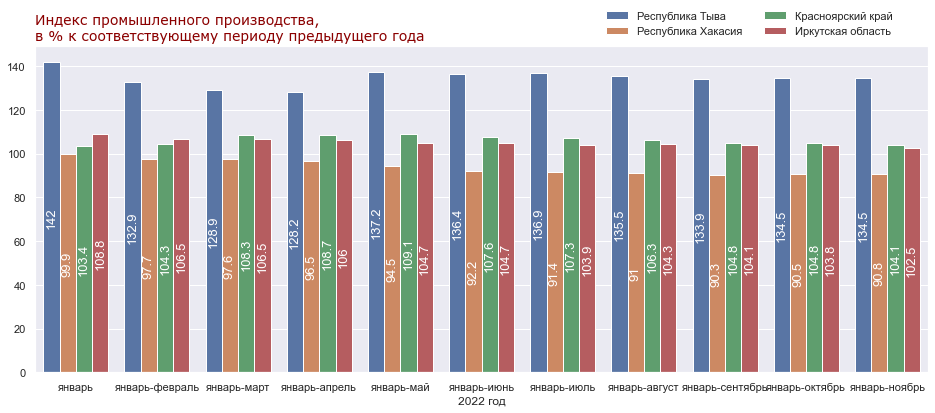

In [13]:
index_idxs = [1]
region_idxs = [75, 76, 78, 79]
year = 2022
regions_barplt(result_df, index_idxs, region_idxs, year)

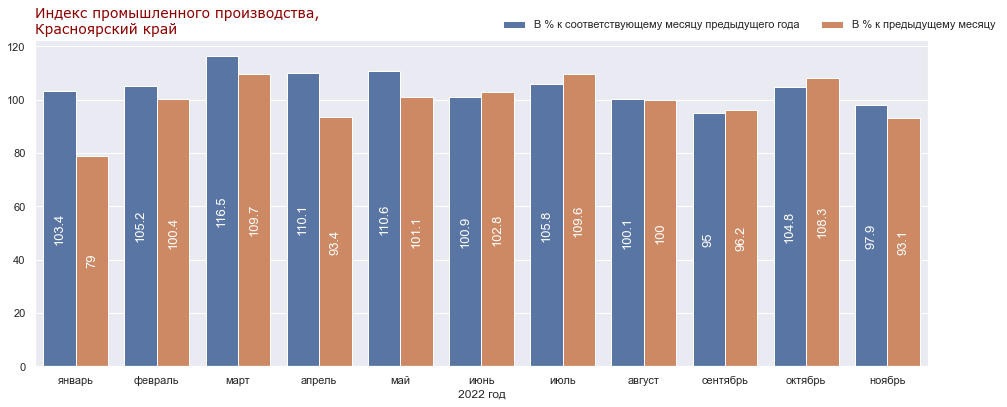

In [14]:
index_idxs = [0, 2]
region_idxs = [78]
year = 2022
regions_barplt(result_df, index_idxs, region_idxs, year)

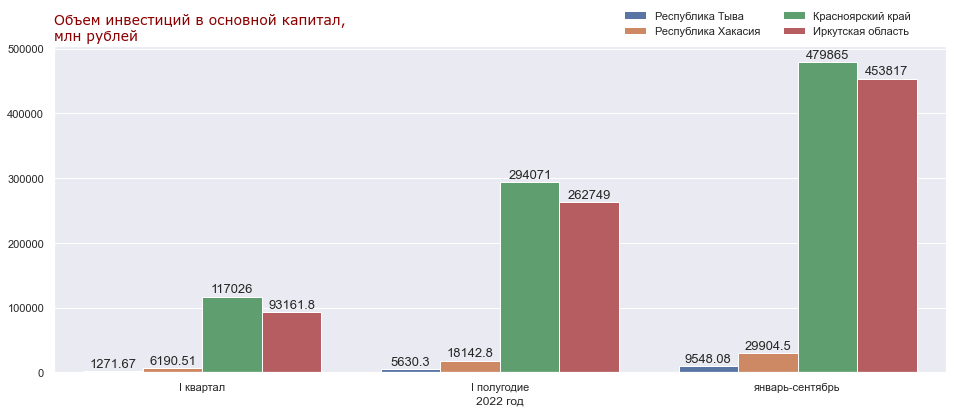

In [15]:
index_idxs = [56]
region_idxs = [75, 76, 78, 79]
year = 2022
regions_barplt(result_df, index_idxs, region_idxs, year)

Достаточно удобными для анализа могут быть комбинированные графики, отображающие один показатель в фактическом выражении и один в процентном. Ниже представлены графики регионов СФО, где отображены данные об объеме инвестиций в основной капитал, в млн рублей по одной вертикальной оси и параллельно динамику в сопоставлении с предыдущим периодом прошлого года в процентном выражении.

In [16]:
def regions_twinplt(df, index_idx_fact, index_idx_percent, region_idxs, year):
    
    #Подготовка выборок для графиков
    sample_l = get_sample(df, index_idx_fact, region_idxs, year)
    sample_r = get_sample(df, index_idx_percent, region_idxs, year)
       
    sns.set_theme(style='white')
    
    #Определение количества рядов в графике
    num_rows = int(np.ceil(len(region_idxs)/2))
    #Определение области построения графиков
    fig, axs = plt.subplots(ncols=2, nrows=num_rows, figsize=(16, 4*num_rows), squeeze=False, constrained_layout=True)
    #Заголовок графика
    fig.suptitle(sample_l.IndexTitle.iloc[0])
    
    for ax_, reg_id in list(zip(axs.ravel(), region_idxs)):
        
        #Построение графиков в фактическом выражении
        data_sample_l = sample_l.query('Region_id == @reg_id')
        ax_ = sns.barplot(ax=ax_, y='Index', x='PeriodName', data=data_sample_l)
        ax_.set_title(data_sample_l.Region_full.iloc[0])
        ax_.bar_label(ax_.containers[0], size=14, padding=-18)
        ax_.set_xlabel('')
        ax_.set_ylabel(sample_l.IndexUnitShort.iloc[0])
        ax_.grid(visible=None)
        ax_.set_xticks([])
        
        #Построение графиков в процентном выражении
        data_sample_r = sample_r.query('Region_id == @reg_id')
        ax_t = ax_.twinx()
        ax_t.set_ylim(bottom=0, top=data_sample_r.Index.max()*1.2, emit=True, auto=False)
        sns.pointplot(ax=ax_t, data=data_sample_r, x='PeriodName', y='Index')
        ax_t.set_ylabel(sample_r.IndexUnitShort.iloc[0])
        for xy in ax_t.collections[0].get_offsets():
            ax_t.annotate(xy[1], (xy[0], xy[1] + 5), color = 'darkblue')
    
    return plt.show()

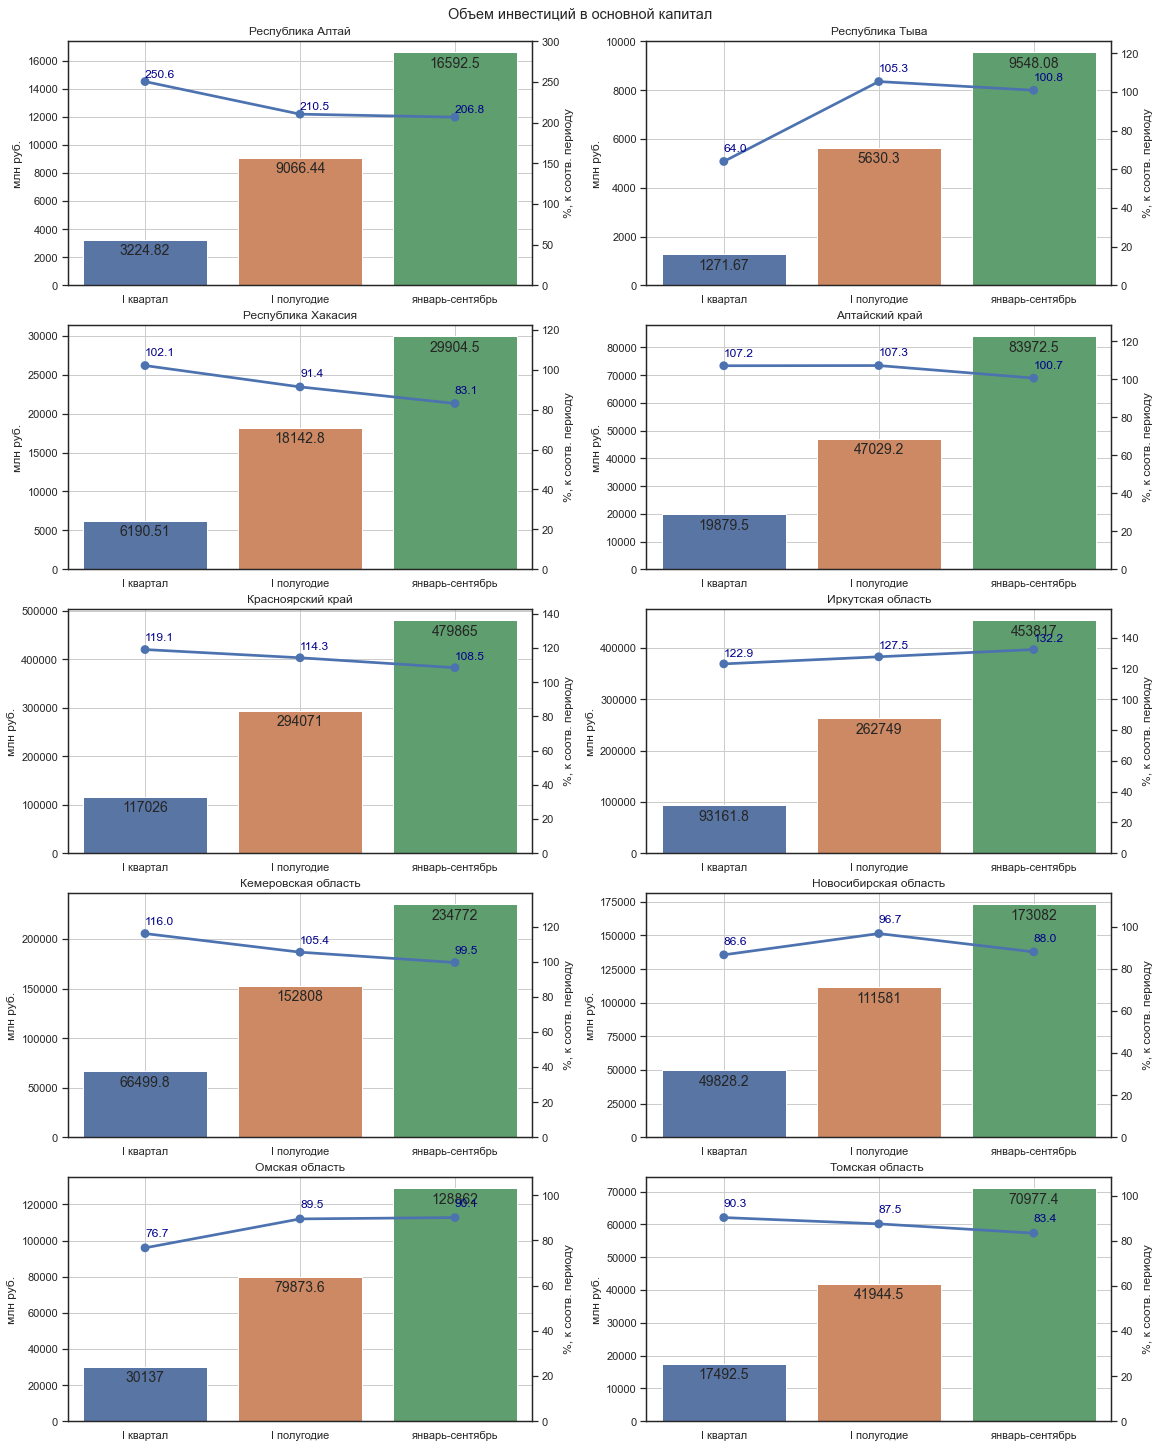

In [17]:
idx_fact = [56]
idx_percent = [57]
region_idxs = [74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
year = 2022
regions_twinplt(result_df, idx_fact, idx_percent, region_idxs, year)

Подготовленный файл также удобно использовать в рамках разнообразных аналитических инструментов, в том числе в Power BI. Пример отчета представлен ниже и по [ссылке](https://github.com/islavunin/regional_statistics/blob/main/data/Regional_statistic.pbix "Файл отчета PowerBI").
<img src = 'Regional_statistics.png'>

## Построение прогнозов статистических показателей
На базе подготовленного датасета можно также осуществить прогноз показателей.
В качестве примера возьмем выборку по показателю "Объем инвестиций в основной капитал" по Красноярскому краю.

In [18]:
sample = result_df.query('Region_id == 78 & Index_id == 56').drop(columns=['Period_id', 'Region_id', 'Index_id']).reset_index(drop=True).copy()
# Добавление характеристики года и квартала
sample['Year'] = sample.Period.dt.year
sample['Quarter'] = sample.Period.dt.quarter
# Определение квартального прироста показателя
sample['IndexPerQ'] = sample.Index - sample.Index.shift(1, fill_value=0)
sample.IndexPerQ = sample.IndexPerQ.mask(sample.IndexPerQ < 0, sample.Index)
# В качестве целевого показателя определяется показатель следующего периода
sample['x'] = sample.IndexPerQ
sample['y'] = sample.IndexPerQ.shift(-1)
sample.head()

,Index,Period,Year,Quarter,IndexPerQ,x,y
0,83059.092000,2016-03-01,2016,1,83059.092000,83059.092000,97229.824000
1,180288.916000,2016-06-01,2016,2,97229.824000,97229.824000,101699.855000
2,281988.771000,2016-09-01,2016,3,101699.855000,101699.855000,143942.870000
3,425931.641000,2016-12-01,2016,4,143942.870000,143942.870000,61870.302859
4,61870.302859,2017-03-01,2017,1,61870.302859,61870.302859,83756.395731


В качестве метрики ошибок для оценки точности прогнозирования временных рядов выбрана МАРЕ - средняя абсолютная ошибка в процентах.

In [19]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

В рамках прогноза предполагается оценить эффективность прогнозирования следующих алгоритмов: линейной регрессии, дерева решений, леса деревьев решений, а также градиентного бустинга на базе библиотеки SciKitLearn, а также регрессионного алгоритма библиотеки Xgboost. Для целей первичной оценки алгоритмы используются без настройки гиперпараметров. В качестве базовой оценки (бенчмарка) взят показатель предыдущего периода.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [21]:
def predict_values_MAPE(train, test):
    
    y_train = train.y.values.reshape(-1, 1)
    X_train = train.drop(['y'], axis=1)
    x_test = test.x.values.reshape(-1, 1)
    y_test = test.y.values.reshape(-1, 1)
    X_test = test.drop(['y'], axis=1)
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    prediction = lm.predict(X_test)

    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_train, y_train)
    tree_prediction = tree.predict(X_test)

    forest = RandomForestRegressor(random_state=42)
    forest.fit(X_train, y_train.ravel())
    forest_prediction = forest.predict(X_test)

    gb = GradientBoostingRegressor(random_state=42)
    gb.fit(X_train, y = y_train.ravel())
    gb_prediction = gb.predict(X_test)
    
    xgb_r = xgb.XGBRegressor(seed = 42)
    xgb_r.fit(X_train, y_train)
    xgb_prediction = xgb_r.predict(X_test)
    
    print('X_test MAPE, %', mape(y_test, x_test))
    print('LinearRegression MAPE, %', mape(y_test, prediction))
    print('DecisionTree MAPE, %', mape(y_test, tree_prediction))
    print('RandomForest MAPE, %', mape(y_test, forest_prediction))
    print('GradientBoosting MAPE, %', mape(y_test, gb_prediction))
    print('XGBoost MAPE, %', mape(y_test, xgb_prediction))
    

С учетом ограниченной выборки в тренировочный датасет включена информация за 2016-2020 года, в валидационный - информация с начала 2021 года. Если строить прогноз только на данных предыдущего периода наилучшую точность показывает предыдущий период :)

In [22]:
pred_cols = ['x', 'y']
train = sample[pred_cols][:-7]
test = sample[pred_cols][-7:-1]
predict_values_MAPE(train, test)

X_test MAPE, % 32.89
LinearRegression MAPE, % 37.15
DecisionTree MAPE, % 46.66
RandomForest MAPE, % 41.31
GradientBoosting MAPE, % 46.57
XGBoost MAPE, % 46.66


При добавлении в датасет данных о годе и квартале немного лучший результат показывают Random Forest и Gradient Boosting, однако величина ошибки по метрике МАРЕ все еще очень велика.

In [23]:
pred_cols = ['Year', 'Quarter', 'x', 'y']
train = sample[pred_cols][:-7]
test = sample[pred_cols][-7:-1]
predict_values_MAPE(train, test)

X_test MAPE, % 32.89
LinearRegression MAPE, % 57.78
DecisionTree MAPE, % 44.45
RandomForest MAPE, % 26.55
GradientBoosting MAPE, % 25.81
XGBoost MAPE, % 34.55


Расширение датасета путем преобразования категориальной переменной Quarter в dummy-переменные дает заметный прирост в качестве прогноза линейной регрессии, но в целом ошибка также велика как и раньше.

In [24]:
dum_sample = pd.get_dummies(data=sample, prefix='q', columns=['Quarter'])
cols = ['x', 'y', 'q_1', 'q_2', 'q_3', 'q_4']
train = dum_sample[cols][:-7]
test = dum_sample[cols][-7:-1]
predict_values_MAPE(train, test)

X_test MAPE, % 32.89
LinearRegression MAPE, % 20.97
DecisionTree MAPE, % 44.65
RandomForest MAPE, % 40.02
GradientBoosting MAPE, % 41.69
XGBoost MAPE, % 42.4


Для улучшения прогноза соберем сводную таблицу по годам, с помощью которой на базе 3-х кварталов будем прогнозировать четвертый. С учетом ограниченности выборки проведем кросс-валидацию по отдельным объектам (Leave-One-Out).
Результат прогнозирования будет сведен в общую таблицу с результатом прогноза и оценкой его ошибки по каждому году и каждому алгоритму.

In [25]:
pvt_sample_q = sample.pivot(index='Year', columns='Quarter', values='IndexPerQ')
pvt_sample_q.rename(columns={1:'x1', 2:'x2', 3:'x3', 4:'y'}, inplace=True)

In [26]:
def predict_values_MAPE_pvt(train, test, columns):
    
    y_train = train.y.values.reshape(-1, 1)
    X_train = train.drop(['y'], axis=1)
    prev_x_test = test.x3.values.reshape(-1, 1)
    y_test = test.y.values.reshape(-1, 1)
    X_test = test.drop(['y'], axis=1)
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    prediction = lm.predict(X_test)

    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_train, y_train)
    tree_prediction = tree.predict(X_test)

    forest = RandomForestRegressor(random_state=42)
    forest.fit(X_train, y_train.ravel())
    forest_prediction = forest.predict(X_test)

    gb = GradientBoostingRegressor(random_state=42)
    gb.fit(X_train, y = y_train.ravel())
    gb_prediction = gb.predict(X_test)
    
    xgb_r = xgb.XGBRegressor(seed = 42)
    xgb_r.fit(X_train, y_train)
    xgb_prediction = xgb_r.predict(X_test)
    
    result = pd.DataFrame(data=[y_test[0][0], 
                        prev_x_test[0][0], mape(y_test, prev_x_test),
                        prediction[0][0], mape(y_test, prediction),
                        tree_prediction[0], mape(y_test, tree_prediction),
                        forest_prediction[0], mape(y_test, forest_prediction),
                        gb_prediction[0], mape(y_test, gb_prediction), 
                        xgb_prediction[0], mape(y_test, xgb_prediction)],
                        columns=test.index, index = columns
                         )
    
    return result

In [27]:
from sklearn.model_selection import LeaveOneOut
def mape_llo(sample):
    loo = LeaveOneOut()
    columns = ['Y', 'Y[-1]', 'Y[-1], %', 'LR', 'LR, %', 'DT', 'DT, %', 'RF', 'RF, %', 'GB', 'GB, %', 'XGB', 'XGB, %']
    mape_results = pd.DataFrame(columns=columns)
    for train, test in loo.split(sample):
        result = predict_values_MAPE_pvt(sample.iloc[train], sample.iloc[test], columns)
        mape_results = pd.concat([mape_results, result.T])
    return mape_results

In [28]:
pd.options.display.float_format ='{:,.1f}'.format
pvtq_results = mape_llo(pvt_sample_q[:-1])
pvtq_results

,Y,Y[-1],"Y[-1], %",LR,"LR, %",DT,"DT, %",RF,"RF, %",GB,"GB, %",XGB,"XGB, %"
2016,"143,942.9","101,699.9",29.4,"140,771.9",2.2,"158,704.7",10.3,"171,638.3",19.2,"159,840.3",11.0,"172,721.2",20.0
2017,"169,196.3","106,063.4",37.3,"199,589.4",18.0,"143,942.9",14.9,"163,364.5",3.5,"153,963.9",9.0,"162,898.9",3.7
2018,"162,899.0","100,862.3",38.1,"157,103.1",3.6,"169,196.3",3.9,"161,107.3",1.1,"163,050.8",0.1,"154,468.2",5.2
2019,"158,704.7","99,865.7",37.1,"211,814.4",33.5,"143,942.9",9.3,"157,520.3",0.8,"143,943.8",9.3,"145,372.8",8.4
2020,"201,515.0","112,825.1",44.0,"177,264.3",12.0,"162,899.0",19.2,"159,168.1",21.0,"161,209.2",20.0,"168,885.2",16.2
2021,"212,269.7","158,142.9",25.5,"320,935.0",51.2,"201,515.0",5.1,"174,702.4",17.7,"201,514.1",5.1,"175,703.2",17.2


#### Результат прогноза
Кросс-валидация показала, что качество прогноза алгоритмов сильно различается от года к году: где-то лучшим выступает градиентный бустинг, а где-то простая линейная регрессия.
Если посмотреть на ошибку агрегированных результатов по всем алгоритмам (ниже), среднее значение из всех прогнозов показывает наименьшую ошибку. Соответственно можно сделать вывод, что с учетом ограниченности данных средний показатель ансамбля алгоритмов "из коробки" имеет наилучшее качество (5,92%) и может быть применим для прогнозирования завершающих периодов на основе фактических данных с начала года.

In [29]:
aggcols = ['LR', 'DT', 'RF', 'GB', 'XGB']
pvtq_results['AVG'] = pvtq_results[aggcols].mean(axis = 1)
pvtq_results['MIN'] = pvtq_results[aggcols].min(axis = 1)
pvtq_results['MAX'] = pvtq_results[aggcols].max(axis = 1)
pvtq_results['MED'] = pvtq_results[aggcols].median(axis = 1)
aggcols.extend(['MIN', 'MAX', 'AVG', 'MED'])
for i in aggcols:
    print(i + ':', mape(pvtq_results.Y, pvtq_results[i]), '%')

LR: 20.07 %
DT: 10.43 %
RF: 10.54 %
GB: 9.08 %
XGB: 11.78 %
MIN: 11.72 %
MAX: 23.09 %
AVG: 5.92 %
MED: 8.08 %
